# Calculate Background

## Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from astropy.table import Table
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid
import json
import os

## Backgrounds

Sky emission curves in optical and infrared wavelength ranges are saved in `../Data/backgrounds/`

`highsky.dat`: optical sky background taken from [HST](https://hst-docs.stsci.edu/acsihb/chapter-9-exposure-time-calculations/9-7-tabular-sky-backgrounds), in $\rm erg/s/cm^2/angstrom/arcsec^2$ - $\rm angstrom$;

`background_earth.txt`: sky background from 0.5 to 30 micron at earth orbit from [here](https://irsa.ipac.caltech.edu/applications/BackgroundModel/), in $\rm MJy/sr$ - $\rm micron$;  

`background_l2.txt`: sky background from 0.5 to 30 micron at L2 point from [here](https://irsa.ipac.caltech.edu/applications/BackgroundModel/), in $\rm MJy/sr$ - $\rm micron$;  

`jwstbg.txt`: sky background from 0.5 to 30 mircon specifically for JWST obtained by [jwst_backgrounds](https://github.com/spacetelescope/jwst_backgrounds), in in $\rm MJy/sr$ - $\rm micron$.  

`skybg_50_10.dat`: sky background in optical at site Maunakea from [here](https://www.gemini.edu/observing/telescopes-and-sites/sites#OptSky), in $\rm phot/s/nm/arcsec^2/m^2$ - $\rm nm$.

In [2]:
data_path = '../Data'
bkg_path = os.path.join(data_path, 'backgrounds')

In [3]:
highsky = np.loadtxt(bkg_path + '/highsky.dat')
earth = Table.read(bkg_path + '/background_earth.txt',
                              format='ipac', 
                              include_names=['wavelength', 'totbg', 'obsloc'])
l2 = Table.read(bkg_path + '/background_l2.txt',
                              format='ipac', 
                              include_names=['wavelength', 'totbg', 'obsloc'])
jwstbg = np.loadtxt(bkg_path + '/jwstbg.txt')
sky_bg_50_10 = np.loadtxt(bkg_path + '/skybg_50_10.dat', skiprows=14)

## Conversion

From $\rm erg/s/cm^2/angstrom/arcsec^2$ to $\rm MJy/sr$ for `highsky.dat`: 
$$
f_\nu = \frac{\lambda^2}{c}f_\lambda
$$

In [4]:
highsky_in_MJy_sr = (highsky[:, 1] * (u.erg/u.s/u.cm**2/u.angstrom/u.arcsec**2)\
                    * (highsky[:, 0] * u.angstrom)**2 / const.c).to(u.MJy/u.sr).value

From $\rm phot/s/nm/arcsec^2/m^2$ to $\rm MJy/sr$ for `sky_bg_50_in.dat`:

In [5]:
sky_emission = sky_bg_50_10[:, 1] * (u.s**-1 * u.nm**-1 * u.arcsec**-2 * u.m**-2)
sky_wavelength = sky_bg_50_10[:, 0] * u.nm

sky_emission = sky_emission * (const.h * const.c / (sky_wavelength))
sky_emission = sky_emission.to(u.erg/u.s/u.cm**2/u.angstrom/u.arcsec**2)

sky_bg_in_MJy_sr = (sky_emission \
                    * (sky_wavelength)**2 / const.c).to(u.MJy/u.sr)
sky_bg_in_MJy_sr = sky_bg_in_MJy_sr.value

sky_wavelength = sky_wavelength.to(u.angstrom)
sky_wavelength = sky_wavelength.value

## Standardize

In [6]:
# in AA - MJy/sr
background_optical = np.column_stack((highsky[:, 0], highsky_in_MJy_sr))
background_earth = np.column_stack((earth['wavelength'] * 10**4, earth['totbg']))
background_l2 = np.column_stack((l2['wavelength'] * 10**4, l2['totbg']))
background_jwst = np.column_stack((jwstbg[:, 0] * 10**4, jwstbg[:, 1]))
background_Maunakea = np.column_stack((sky_wavelength, sky_bg_in_MJy_sr))

Text(0, 0.5, 'Flux [MJy/sr]')

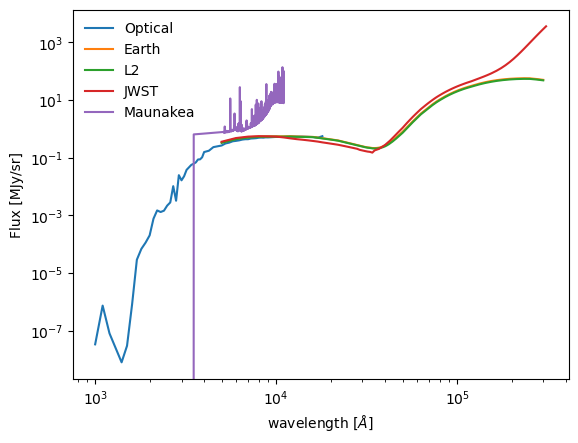

In [7]:
plt.plot(background_optical[:, 0], background_optical[:, 1], label='Optical')
plt.plot(background_earth[:, 0], background_earth[:, 1], label='Earth')
plt.plot(background_l2[:, 0], background_l2[:, 1], label='L2')
plt.plot(background_jwst[:, 0], background_jwst[:, 1], label='JWST')
plt.plot(background_Maunakea[:, 0], background_Maunakea[:, 1], label='Maunakea')
plt.yscale('log')
plt.xscale('log')
plt.legend(frameon=False)
plt.xlabel(r'wavelength [$\AA$]')
plt.ylabel('Flux [MJy/sr]')

## Sky background calculation

$$
B_{\rm sky} = A_{\rm eff}\int I_{\rm sky}l_p^2\tau(\lambda)\frac{\lambda}{hc}d\lambda
$$  
where $A_{\rm eff}$, $I_{\rm sky}$, $l_p$ and $\tau(\lambda)$ are effective area, sky emission intensity, pixelscale and throughput respectively. And $h$ and $c$ are Planck's constant and speed of light respectively.

In [8]:
def calc_bkg(bkg_curve, throughput, aperture, pixelscale):
    I_sky = ((bkg_curve[:, 1] * (u.MJy/u.sr) * const.c) \
        / (bkg_curve[:, 0] * u.angstrom)**2).to(u.erg/u.s/u.cm**2/u.angstrom/u.arcsec**2)
    I_sky_interp = interp1d(bkg_curve[:, 0], I_sky.value, kind='linear', bounds_error=False,
                            fill_value=0)
    throughput = throughput[throughput[:, 1] > 10**-4]
    I_sky_in_fil = I_sky_interp(throughput[:, 0]) * (u.erg/u.s/u.cm**2/u.angstrom/u.arcsec**2)
    wave = throughput[:, 0] * u.angstrom
    thr = throughput[:, 1]
    integral = trapezoid(wave * I_sky_in_fil * thr, wave)
    factor = np.pi * (aperture / 2 * u.m)**2 * (pixelscale * u.arcsec)**2 / (const.c * const.h)
    Bsky = factor * integral
    Bsky = Bsky.to(1 / u.s)
    Bsky = Bsky.value
    return Bsky

In [9]:
def main(survey, filters, info, bkg_curve, suffix=None, show_thr=False, show_bkg_curve=False):

    if isinstance(filters, str):
        filters = [filters]

    if show_bkg_curve | show_thr:
        fig, ax1 = plt.subplots()
    
    survey_bskys = []
    minw = []
    maxw = []
    for i, fil in enumerate(filters):
        thr = np.loadtxt(data_path + f'/filters/{survey}/{fil}.fil')
        minw.append(np.min(thr[:, 0]))
        maxw.append(np.max(thr[:, 0]))

        if show_thr:
            ax1.plot(thr[:, 0], thr[:, 1], label=fil)
            ax1.set_xlabel('wavelength')
            ax1.set_ylabel('Throughputs')
        Bsky = calc_bkg(bkg_curve, thr, info['aperture'], info['pixelscale'])

        print(f'{survey}.{fil}: {Bsky:.4f}')
        survey_bskys.append(Bsky)

    if show_thr:
        ax1.set_xlim(np.min(minw) - 1000, np.max(maxw) + 1000)

    if show_bkg_curve:
        ax2 = ax1.twinx()
        ax2.plot(bkg_curve[:, 0], bkg_curve[:, 1], c='gray', 
                 linestyle='dashed', label='sky_bkg')
        ax2.set_ylim(np.min(bkg_curve[:, 1]), np.max(bkg_curve[:, 1]))
        ax2.set_ylabel('Emission [MJy/sr]')
        ax2.set_yscale('log')

    survey_bskys = [str(np.around(b, 4)) for b in survey_bskys]

    if suffix is not None:
        survey = f'{survey}_{suffix}'
    
    

    data = {f'{survey}':
            {
                f'{survey}_bands': ','.join(filters),
                f'{survey}_sky_bkg': ','.join(survey_bskys),
                f'{survey}_aperture': str(np.around(info['aperture'], 2)),
                f'{survey}_pixelscale': str(np.around(info['pixelscale'], 3)),
                f'{survey}_Bdark': str(np.around(info['Bdark'], 3)),
                f'{survey}_Readout' : str(np.around(info['Readout'], 2))
            }
            }
    
    
    if 'numExposures' in info.keys():
        numExp = [str(num) for num in info['numExposures']]
        data[f'{survey}'][f'{survey}_numExposures'] = ','.join(numExp)
    
    if os.path.exists(bkg_path + '/skyBkgNoise.json'):
        with open(bkg_path + '/skyBkgNoise.json', 'r') as f:
            bkg_data = json.load(f)
    else:
        bkg_data = {}

    bkg_data = bkg_data | data

    with open(bkg_path + '/skyBkgNoise.json', 'w') as f:
        json.dump(bkg_data, f, indent=4)

## CSST

CSST.NUV: 0.0042
CSST.u: 0.0317
CSST.g: 0.2803
CSST.r: 0.3591
CSST.i: 0.3708
CSST.z: 0.2168
CSST.y: 0.0638


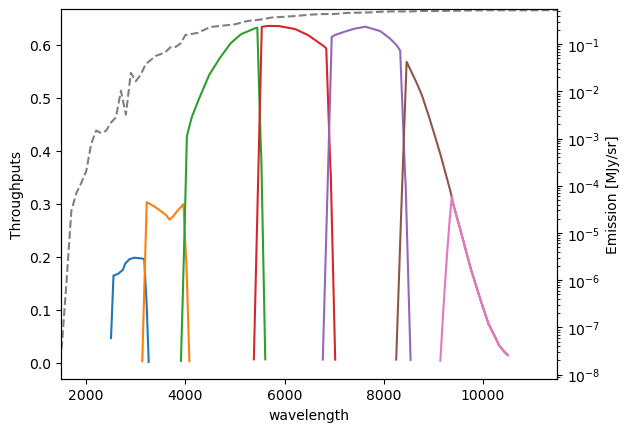

In [30]:
info = {}
info['Bdark'] = 0.02
info['Readout'] = 5
info['aperture'] = 2.0
info['pixelscale'] = 0.074
info['numExposures'] = [4, 2, 2, 2, 2, 2, 4]

CSST_bands = ['NUV', 'u', 'g', 'r', 'i', 'z', 'y']

main('CSST', CSST_bands, info, background_optical, show_thr=True, show_bkg_curve=True)

## HST WFC3

Instrumental parameters of UVIS and IR of WFC3 can be found [here](https://www.stsci.edu/hst/instrumentation/wfc3/instrument-design/)

### UVIS

HST.UV_F225W: 0.0001
HST.UV_F275W: 0.0004
HST.UV_F336W: 0.0039
HST.UV_F390W: 0.0181
HST.UV_F438W: 0.0175
HST.UV_F467M: 0.0076
HST.UV_F555W: 0.0674
HST.UV_F606W: 0.1018
HST.UV_F775W: 0.0435
HST.UV_F814W: 0.0562


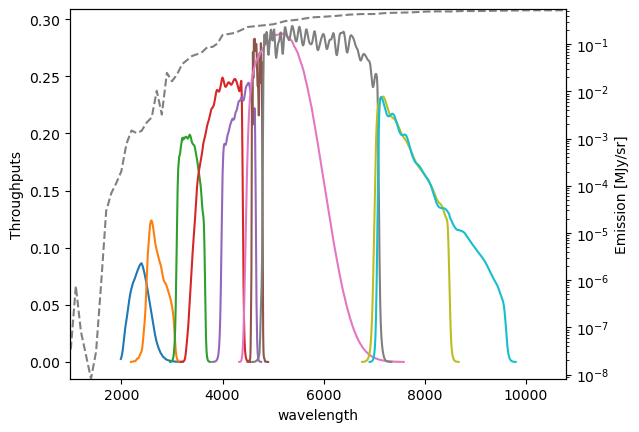

In [31]:
info = {}
info['Bdark'] = 3 / (60 * 60)
info['Readout'] = 3.1
info['aperture'] = 2.4
info['pixelscale'] = 0.04

HST_UV_bands = ['UV_F225W', 'UV_F275W', 'UV_F336W', 'UV_F390W', 'UV_F438W',
                'UV_F467M', 'UV_F555W', 'UV_F606W', 'UV_F775W', 'UV_F814W']

main('HST', HST_UV_bands, info, background_optical, suffix='UV', show_thr=True, show_bkg_curve=True)

### IR

HST.IR_F105W: 1.9397
HST.IR_F110W: 3.2075
HST.IR_F125W: 1.8718
HST.IR_F140W: 2.2485
HST.IR_F160W: 1.3786


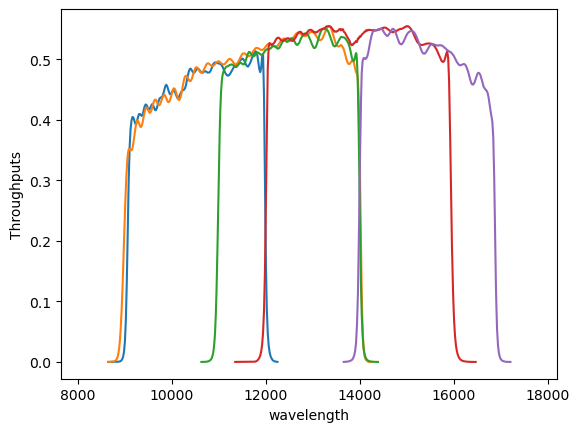

In [37]:
info = {}
info['Bdark'] = 0.048
info['Readout'] = 21
info['aperture'] = 2.4
info['pixelscale'] = 0.13

HST_IR_bands = ['IR_F105W', 'IR_F110W', 'IR_F125W', 'IR_F140W', 'IR_F160W']

main('HST', HST_IR_bands, info, background_earth, suffix='IR',
      show_thr=True, show_bkg_curve=False)

## JWST

Instrumental parameters for JWST can be found [here](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-instrumentation/nircam-detector-overview/nircam-detector-performance#gsc.tab=0) and [here](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-instrumentation/nircam-detector-overview#gsc.tab=0)

### Long

JWST.F250M: 0.3319
JWST.F277W: 1.1002
JWST.F300M: 0.4286
JWST.F322W2: 2.3296
JWST.F323N: 0.0305
JWST.F335M: 0.4334
JWST.F356W: 1.1707
JWST.F360M: 0.5105
JWST.F405N: 0.0681
JWST.F410M: 0.8645
JWST.F430M: 0.5457
JWST.F444W: 3.2627
JWST.F460M: 0.7500
JWST.F466N: 0.1348
JWST.F470N: 0.1297
JWST.F480M: 1.2129


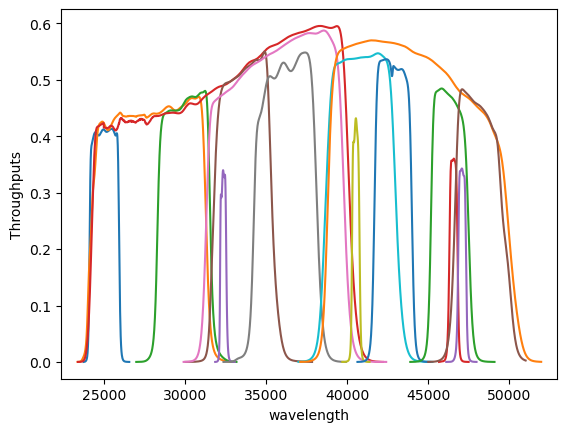

In [38]:
info = {}
info['Bdark'] = 34.2 / 1000
info['Readout'] = 13.25
info['aperture'] = 6.5
info['pixelscale'] = 0.063

JWST_long_bands = ['F250M', 'F277W', 'F300M', 'F322W2', 
             'F323N', 'F335M', 'F356W', 'F360M', 
             'F405N', 'F410M', 'F430M', 'F444W', 
             'F460M', 'F466N', 'F470N', 'F480M']

main('JWST', JWST_long_bands, info, background_jwst, suffix='Long', 
     show_thr=True, show_bkg_curve=False)

### Short

JWST.F070W: 0.3307
JWST.F090W: 0.4487
JWST.F115W: 0.4273
JWST.F140M: 0.2171
JWST.F150W2: 1.6239
JWST.F150W: 0.4721
JWST.F162M: 0.2133
JWST.F164N: 0.0212
JWST.F182M: 0.2502
JWST.F187N: 0.0206
JWST.F200W: 0.4326
JWST.F210M: 0.1744
JWST.F212N: 0.0187
JWST.WLP4: 0.0425


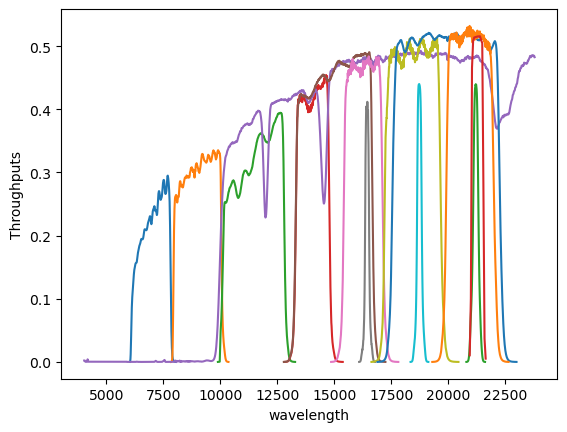

In [39]:
info = {}
info['Bdark'] = 1.9 / 1000
info['Readout'] = 15.77
info['aperture'] = 6.5
info['pixelscale'] = 0.031

JWST_short_bands = ['F070W', 'F090W', 'F115W', 'F140M', 
              'F150W2', 'F150W', 'F162M', 'F164N', 
              'F182M', 'F187N', 'F200W', 'F210M', 
              'F212N', 'WLP4']

main('JWST', JWST_short_bands, info, background_jwst, suffix='Short', 
     show_thr=True, show_bkg_curve=False)

## Roman

Instrumental parameters for Roman can be found in [here](https://roman.ipac.caltech.edu/sims/Param_db.html) and [here](https://roman-docs.stsci.edu/roman-instruments-home/wfi-imaging-mode-user-guide/introduction-to-wfi/wfi-quick-reference)

Roman.F062: 7.1684
Roman.F087: 6.6275
Roman.F106: 7.0874
Roman.F129: 7.1373
Roman.F158: 7.0349
Roman.F184: 4.1791
Roman.F213: 3.5150
Roman.F146: 21.3173


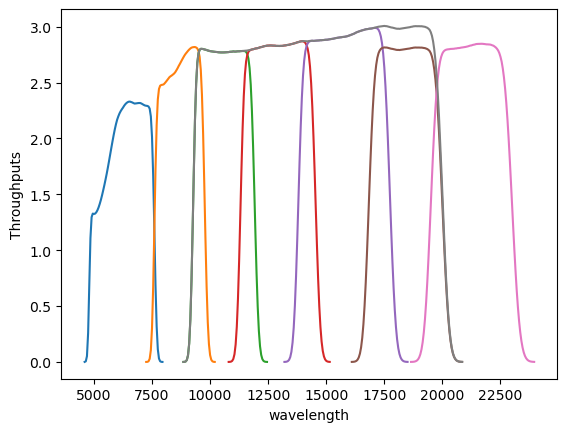

In [40]:
info = {}
info['Bdark'] = 0.1
info['Readout'] = 20
info['aperture'] = 2.36
info['pixelscale'] = 0.11

Roman_bands = ['F062', 'F087', 'F106', 'F129', 
               'F158', 'F184', 'F213', 'F146'] # need investigation

main('Roman', Roman_bands, info, background_l2, 
     show_thr=True, show_bkg_curve=False)

## Euclid

Some instrumetal parameters for VIS and NISP can be found [here](https://sci.esa.int/web/euclid/-/euclid-vis-instrument) and [here](https://sci.esa.int/web/euclid/-/euclid-vis-instrument).  
And please refer to papers for [VIS](https://arxiv.org/abs/2405.13492) and [NISP](https://arxiv.org/abs/2405.13493) for more details.

### VIS

Euclid.VIS: 0.7162


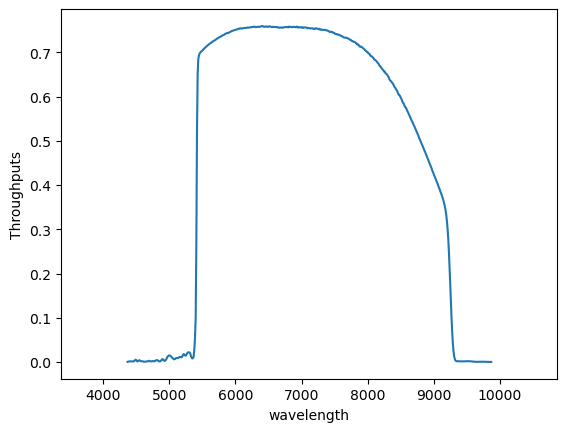

In [42]:
info = {}
info['Bdark'] = 0.005
info['Readout'] = 2.2
info['aperture'] = 1.2
info['pixelscale'] = 0.1

Euclid_VIS_bands = 'VIS'

main('Euclid', Euclid_VIS_bands, info, background_l2, suffix='VIS',
     show_thr=True, show_bkg_curve=False)

Euclid.Y: 3.6863
Euclid.J: 4.4556
Euclid.H: 3.8228


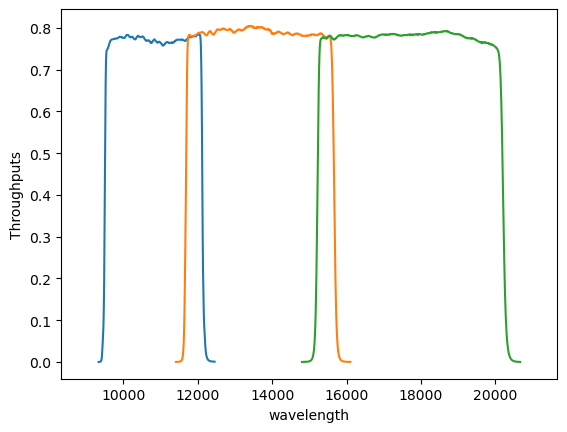

In [43]:
info = {}
info['Bdark'] = 0.02
info['Readout'] = 6
info['aperture'] = 1.2
info['pixelscale'] = 0.3

Euclid_NISP_bands = ['Y', 'J', 'H']

main('Euclid', Euclid_NISP_bands, info, background_l2, suffix='NISP',
     show_thr=True, show_bkg_curve=False)

## HSC-SSP

Instrumental parameters can be found in their [paper](https://watermark.silverchair.com/pasj_70_sp1_s4.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAA3owggN2BgkqhkiG9w0BBwagggNnMIIDYwIBADCCA1wGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMv2a3w5xqFX7jKq3uAgEQgIIDLfpzf-SeMlWapM0aw_FDufL2nbanRQYkf8o4HJ4Fw88kGxGighsY11ywUbBIBL4VXtXFvdY8Gjt_wyDv0RiDBZhEIfSzdrBt-C1VKQEdGflNUR4HyMxFj3VVNvFsigZKBS2PzLY0kmZfORM3EqBZxfHkuywWkB3X0qO54i8jLRchtnQY1oxs0pCG4FX8S3FDfc_1039WXBGM3y3FYV4wnh4FtF_pMDUrZvy4wO4d_dYANZIHkt8vN0uElRXOawvTzU6I1DEDDalJJovvPTJPiwj4-vlpcSaOGxJmH8UYXStG5taDvLudoHhvy5CCbBJluNuIooJGkaWiKu1Z2kaPpMkYROCkIrwJau9Yk90D4rsuW439gJBWSGmwfLOsmABZmHqj_1Ud1yqz7zPqoskeav-WkU0Vf050EAePqeVzveesRCZTGbn0stmJBdvOousLEfc8KwQPpH2A_grgXVROaxGhbhjgaUms1PAglOjYx1Lkj9WLEwWxApBunQAe90OOlb5pjkvtq-FYaoH0eSn17W0VTUv2PMtXYzquSwfG9wP8usjqaYKK9FsAMkdywoyAuIHtnIxL0gNbOcLYB6a2h-u1VFtaqH9HKmfqBkisKYj55xhCZQ927UeT3V3nmF-7juLVpzSAMoIl-dOln5KHMH8HJVjKbx08DCk1uySqw7abChhzsw2EyaHEfDs0p9-_JF-X9O1t3dXTu2s7DsYLMqUEoVDFFovJuvk2GBLSlLYIi2HdoLjb-IvqO7jchbpEDe5T94R8-gw9TSGwI9z0jV-j_EK78AfCFzz7VCxA8f3VCmXkzKm2Y4mJOOxf8h_2l2DjzUKFXNrvy9GtptEwrRDY9Fv84_Hnx2D6DX_Aw374e2FNJcFd6mDSymyGFxvhOJH8AnE4GbMpQKOAiDyf-XY_BTXClWozRb919x1MrIuswhdCZgPJOSSS-2g8bStqp4zmfdGn0mWidMr_NUeSdavNye6JJa55cDkCfqeunwfyW8iA1sZX5bwhT1ULTPDgMaXCRwGvyzWDy_DG3zRLhS2CNTns1PohXesRRtr5R-8ZNwfpv2TwcXurv6I0Lw)

HSC.g: 49.9830
HSC.r: 79.8137
HSC.i: 91.8011
HSC.z: 107.2050
HSC.y: 198.5708
HSC.nb816: 6.8434
HSC.nb921: 25.0379


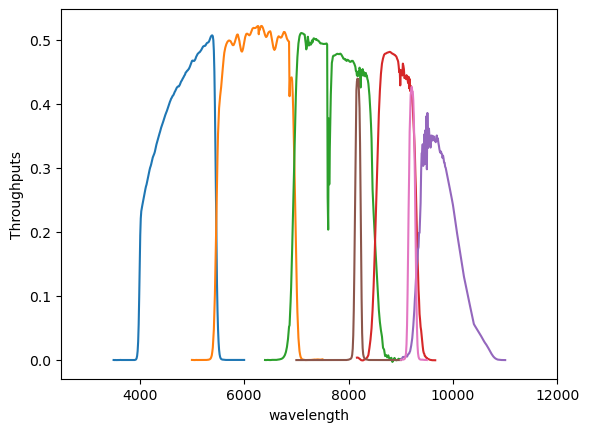

In [ ]:
info = {}
info['Bdark'] = 0
info['Readout'] = 4.5
info['aperture'] = 8.2
info['pixelscale'] = 0.168

HSC_bands = ['g', 'r', 'i', 'z', 'y', 'nb816', 'nb921']0

main('HSC', HSC_bands, info, background_Maunakea, 
     show_thr=True, show_bkg_curve=False)